# Current Analysis
Updated: 2022-08-12 14:25

| Field | Value |
|--|--|
| Block start date | Mar-22-2022 04:36:03 AM +UTC |
| Block end date | Jun-23-2022 10:03:37 AM +UTC|
| Time period | 3 mths 1 day 5h 27m |
| Block start | 14434001 |
| Block end | 15012398 |

In [1]:
from datetime import datetime
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import glob
import ujson as json
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests as r
import seaborn as sns

In [19]:
N = 500 # top N to addresses
API_KEY = os.environ['ETHERSCAN_API_TOKEN']

MIN_BLOCK = 14434001
MAX_BLOCK = 15012398

REDUCED_DATA_PATH = 'data/blocks-reduced'
SOURCE_CODE_SAVE_DIR = 'source-code'
DATAFRAME_SAVE_PATH = f'data/top-{N}-minblock-{MIN_BLOCK}-maxblock-{MAX_BLOCK}.feather'

# for now, min and max blocks are manually set :(

CHUNK_VALUE_COUNTS_DATA_PATH = 'data/chunk-to-value-counts'
CHUNK_SIZE = 10_000

os.makedirs(SOURCE_CODE_SAVE_PATH, exist_ok=True)

# Make chunked value counts
There's too much data to process efficiently in memory.

In [3]:
def mk_chunked_value_counts():
    def mk_chunk(reduced):
        """Save data into chunked value counts
        """
        
        df = pd.DataFrame.from_records(reduced)
        vc = df['to'].value_counts()
        min_block, max_block = df['block_number'].min(), df['block_number'].max()
        
        vc.to_json(os.path.join(CHUNK_VALUE_COUNTS_DATA_PATH, f'{min_block}-{max_block}.json'))
        return vc
        
    reduced = []
    data_paths = list(sorted(glob.glob(os.path.join(REDUCED_DATA_PATH, '*.json'))))
        
    for i, path in tqdm(enumerate(data_paths)):
        if i % CHUNK_SIZE == 0 and i != 0:
            mk_chunk(reduced)
            reduced = []

        with open(path) as f:
            reduced_data = json.load(f)
        reduced.extend(reduced_data)

    if len(reduced) > 0:
        mk_chunk(reduced)
mk_chunked_value_counts()

578399it [03:32, 2718.69it/s]


# Load Data

In [4]:
dfs = [
    pd.read_json(path, orient='index') for path in 
    tqdm(list(glob.glob(os.path.join(CHUNK_VALUE_COUNTS_DATA_PATH, '*.json'))))
]
raw = pd.concat(dfs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.47it/s]


In [5]:
df = (
    raw
    .reset_index()
    .rename(columns={'index': 'address', 0: 'num_tx'})
    .groupby('address')
    .sum()
    .reset_index()
    .sort_values('num_tx', ascending=False)
)

In [6]:
df.address.nunique()

10998150

## Num contracts with num transactions distribution (top 10,000, then remove top 500 from that)
Removed top 500 as distribution is (extremely) long-tailed.

/var/folders/k8/zk3t1hw970s24hcwklx_31ww0000gn/T/ipykernel_3163/2407044859.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(df.head(N2).tail(N2-N2_EXCL_TOP).num_tx, kde=False)


Text(0, 0.5, 'Number of contracts')

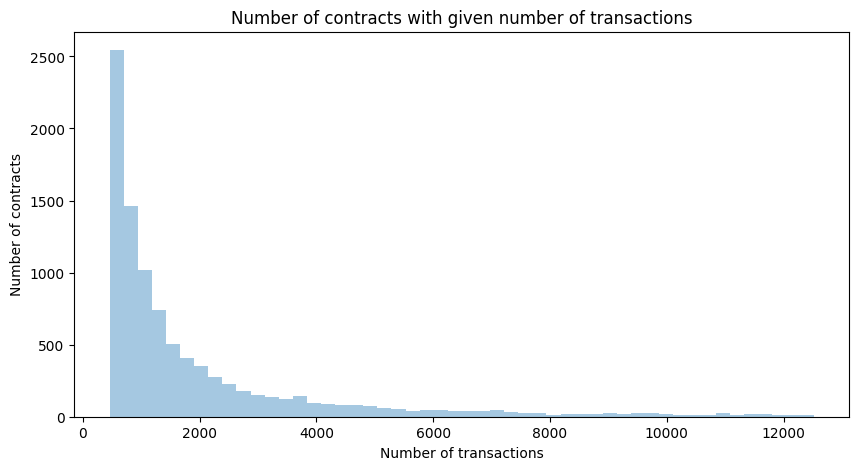

In [7]:
N2 = 10_000
N2_EXCL_TOP = 500

plt.rcParams["figure.figsize"] = (10,5)

p = sns.distplot(df.head(N2).tail(N2-N2_EXCL_TOP).num_tx, kde=False)

p.set_title('Number of contracts with given number of transactions')
p.set_xlabel('Number of transactions')
p.set_ylabel('Number of contracts')

# Get Top N sent addresses

In [8]:
top_N = df.head(N)

In [9]:
top_N

,address,num_tx
10193952,0xdAC17F958D2ee523a2206206994597C13D831ec7,6620945
5500113,0x7f268357A8c2552623316e2562D90e642bB538E5,6169327
4526337,0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45,3408742
6906042,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,2910886
6899686,0xA090e606E30bD747d4E6245a1517EbE430F0057e,2702806
...,...,...
9929479,0xcc0A99F59e7b153bad42f54C278C16E4081Afa7C,12646
9750715,0xc5B52253f5225835cc81C52cdb3d6A22bc3B0c93,12646
9936634,0xccC8cb5229B0ac8069C51fd58367Fd1e622aFD97,12643
8821284,0xFA7E3F898c80E31A3aedeAe8b0C713a3F9666264,12572


## Quick plot to see distro (with top 5 removed)

Text(0.5, 1.0, 'Plot with 5 largest outliers removed')

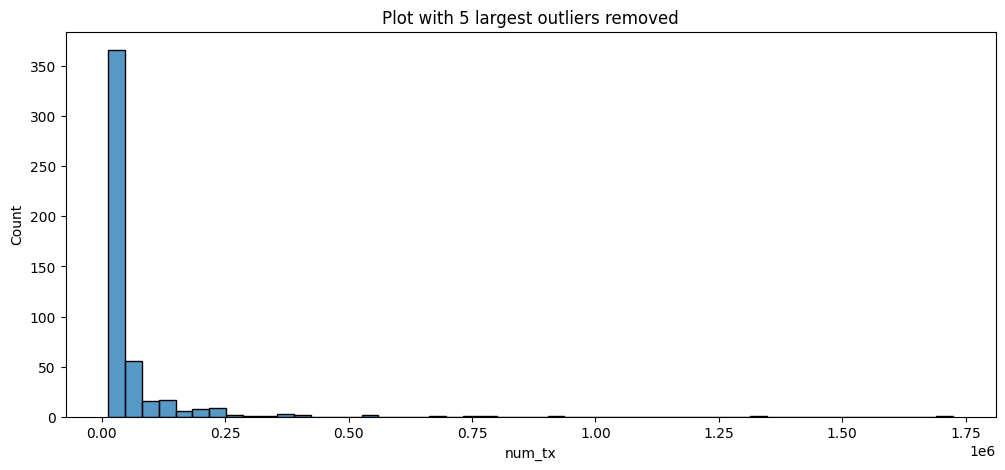

In [10]:
N_REM = 5

plt.subplots(figsize=(12,5))
ax = sns.histplot(top_N.num_tx[N_REM:], bins=50)
ax.set_title('Plot with 5 largest outliers removed')

# Get source code
Takes a while, particularly due to rate limiting

In [11]:
def get_source(address: str) -> dict:
    url = (
        'https://api.etherscan.io/api'
       '?module=contract'
       '&action=getsourcecode'
       f'&address={address}'
       f'&apikey={API_KEY}'
    )
    try:
        res = r.get(url).json()['result'][0]
        res['Address'] = address
    except:
        print('whoops at ' + address)
        
    return res

In [12]:
source_records = [get_source(addr) for addr in tqdm(list(top_N.address))]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:28<00:00,  1.14s/it]


# Final Processing

In [13]:
source_df = pd.DataFrame.from_records(source_records)
final_df = source_df.merge(top_N, how='inner', left_on='Address', right_on='address').drop(columns=['address'])
final_df['frac_tx'] = final_df['num_tx'] / final_df['num_tx'].sum()

In [14]:
final_df.to_feather(DATAFRAME_SAVE_PATH)

In [15]:
final_df.head()

,SourceCode,ABI,ContractName,CompilerVersion,OptimizationUsed,Runs,ConstructorArguments,EVMVersion,Library,LicenseType,Proxy,Implementation,SwarmSource,Address,num_tx,frac_tx
0,pragma solidity ^0.4.17;\r\n\r\n/**\r\n * @tit...,"[{""constant"":true,""inputs"":[],""name"":""name"",""o...",TetherToken,v0.4.18+commit.9cf6e910,0,0,0000000000000000000000000000000000000000000000...,Default,,,0,,bzzr://645ee12d73db47fd78ba77fa1f824c3c8f91840...,0xdAC17F958D2ee523a2206206994597C13D831ec7,6620945,0.126823
1,pragma solidity 0.4.26;\r\n\r\nlibrary SafeMat...,"[{""constant"":true,""inputs"":[],""name"":""name"",""o...",WyvernExchangeWithBulkCancellations,v0.4.26+commit.4563c3fc,1,200,000000000000000000000000a5409ec958c83c3f309868...,Default,,MIT,0,,bzzr://202020202042756c6b20536d617368212121202...,0x7f268357A8c2552623316e2562D90e642bB538E5,6169327,0.118172
2,"{{\r\n ""language"": ""Solidity"",\r\n ""sources""...","[{""inputs"":[{""internalType"":""address"",""name"":""...",SwapRouter02,v0.7.6+commit.7338295f,1,1000000,0000000000000000000000005c69bee701ef814a2b6a3e...,Default,,,1,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,,0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45,3408742,0.065294
3,pragma solidity ^0.4.24;\r\n\r\n// File: zos-l...,"[{""constant"":false,""inputs"":[{""name"":""newImple...",FiatTokenProxy,v0.4.24+commit.e67f0147,0,200,0000000000000000000000000882477e7895bdc5cea7cb...,Default,,,1,0xa2327a938febf5fec13bacfb16ae10ecbc4cbdcf,bzzr://a4a547cfc7202c5acaaae74d428e988bc62ad50...,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,2910886,0.055758
4,,Contract source code not verified,,,,,,Default,,Unknown,0,,,0xA090e606E30bD747d4E6245a1517EbE430F0057e,2702806,0.051772


# Save source code

In [17]:
for row in final_df[final_df.ContractName != ''].itertuples():
    path = os.path.join(SOURCE_CODE_SAVE_DIR, f'{row.ContractName}_{row.Address}.sol')
    with open(path, 'w') as f:
        f.write(row.SourceCode)